In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
# import geopandas as gpd
# import geoplot as gplt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch  # Import Patch
from matplotlib.lines import Line2D

# Figure 2 CI by basin barplot 

In [108]:
# Load data from CSV
df = pd.read_csv(
    '/Users/spencerzhang/GitHub/PhD/North-America-Gas-2021/NAG publishable plot/df_barplot.csv')
df.columns

Index(['Basin', 'Field Count', 'Well Count',
       'Annual Gas Production (MSCF/year)', 'Annual Oil Production (BBL/year)',
       'Annual Flare Volume (BCM/year)', 'Upstream', 'weighted_upstream_CI_lo',
       'weighted_upstream_CI_up', 'Midstream', 'weighted_midstream_CI_lo',
       'weighted_midstream_CI_up', 'Gas production', 'total_CI', 'lo', 'up',
       'lo_diff', 'up_diff'],
      dtype='object')

<Figure size 6000x5400 with 0 Axes>

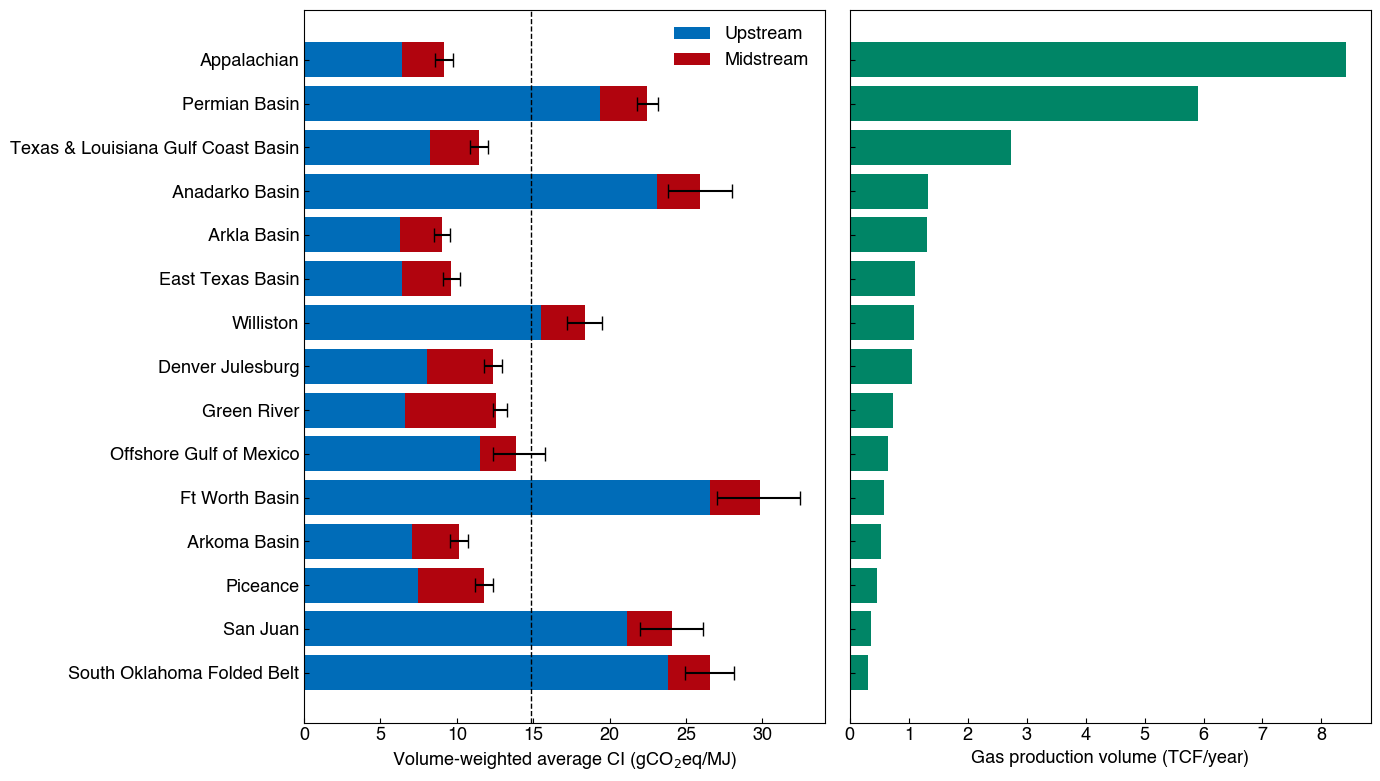

In [109]:
# Set the font properties globally
plt.rcParams['font.family'] = 'Helvetica'
# You can also adjust the size globally here
plt.rcParams['font.size'] = 13

# Create a higher quality figure
plt.figure(figsize=(20, 18), dpi=300)  # Larger figure size and higher DPI

# Sort DataFrame by 'Gas production' in descending order to have the basin with highest production at the top
df['Gas production'] = pd.to_numeric(df['Gas production']/1e9)
df.sort_values(by='Gas production', ascending=True, inplace=True)

# Define a color map for CI categories
# digital
color_map = {
    'Upstream': '#006CB8', # blue
    'Midstream': '#B1040E' # red
}

# # light
# color_map = {
#     'Upstream': '#6FC3FF',  # blue
#     'Midstream': '#E50808'  # red
# }

# # dark
# color_map = {
#     'Upstream': '#00548f',  # blue
#     'Midstream': '#820000'  # red
# }

# Create a figure and two subplots, sharing the y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

# Stacking bars in the first subplot
bottoms = np.zeros(len(df))  # Initial bottom is 0 for each bar
for category in color_map.keys():
    # Get values or zeros if the category is absent
    values = df.get(category, np.zeros(len(df)))
    ax1.barh(df.index, values,
             color=color_map[category], label=category, left=bottoms, alpha=1)
    bottoms += values  # Update bottoms for the next stack

# Setting tick marks to be inside
plt.gca().tick_params(direction='in')

# Configure ticks to be inside for ax1
ax1.tick_params(axis='x', direction='in')
ax1.tick_params(axis='y', direction='in')

ax1.set_xlabel(r'Volume-weighted average CI (gCO$_2$eq/MJ)')
# ax1.set_title('Volume-weighted Average CI per Basin')
ax1.legend(title='', frameon = False)

mean_total_ci = (df['total_CI'] * df['Gas production']).sum()/df['Gas production'].sum()

# Add a vertical line for the mean total CI
ax1.axvline(x=mean_total_ci, color='black', linestyle='--',
            linewidth=1, label=f'Mean Total CI: {mean_total_ci:.2f}')

# Annotate the line with text and an arrow
# ax1.annotate(f'Volume-weighted average CI \n{mean_total_ci:.2f} gCO$_2$eq/MJ',
#              xy=(mean_total_ci, 10), xytext=(mean_total_ci + 3, 10),
#              arrowprops=dict(facecolor='black', shrink=0.05,
#                              width=0.5, headwidth=5),
#              verticalalignment='center', color='black', fontsize=10)


# Adding error bars to the first plot
xerr = df[['lo_diff', 'up_diff']].values.T  # Assuming this is correct
ax1.errorbar(df['total_CI'],
              df['Basin'], xerr=xerr, fmt='none', color='black', capsize=5)

# Second subplot for Gas production volume
ax2.barh(df['Basin'], df['Gas production'],
         color='#008566', # digital green
         #color='#1AECBA', # light green
         #color='#006F54', # dark green
         alpha=1) 
ax2.set_xlabel(r'Gas production volume (TCF/year)')
# ax2.set_title('Gas Production Volume by Basin')

# Tight layout to prevent overlap
plt.tight_layout()

# Setting tick marks to be inside
plt.gca().tick_params(direction='in')

# Show the plot
plt.show()
# Save the plot as a high-quality PNG file
fig.savefig('/Users/spencerzhang/GitHub/PhD/North-America-Gas-2021/NAG publishable plot/volume_weighted_CI_and_gas_production_digital.svg',
            format='svg', dpi=300)


# Figure 3 cumulative CI supply curve

## F3 data prep

In [118]:
fpath = "/Users/spencerzhang/GitHub/PhD/North-America-Gas-2021/NAG publishable plot/df_ci_cumulative_no_coords.csv"
df_viz = pd.read_csv(fpath)


In [111]:
df_viz.columns

Index(['GEOID', 'STATEFP', 'County', 'Basin', 'Well_count', 'Annual_Gas',
       'Annual_Oil', 'Annual_Wat', 'BCM2022', 'Depth', 'Completion', 'C1',
       'C2', 'C3', 'C4+', 'N2', 'CO2',
       '129 Exploration (e) Total energy consumption MJ/MJ',
       '130 Exploration (e) Total GHG emissions gCO2eq/MJ',
       '131 Exploration (e) Total GHG emissions Combustion/land use gCO2eq/MJ',
       '132 Exploration (e) Total GHG emissions VFF gCO2eq/MJ',
       '135 Drilling & Development (d) Total energy consumption MJ/MJ',
       '136 Drilling & Development (d) Total GHG emissions gCO2eq/MJ',
       '137 Drilling & Development (d) Total GHG emissions Combustion/land use gCO2eq/MJ',
       '138 Drilling & Development (d) Total GHG emissions VFF gCO2eq/MJ',
       '141 Crude production & extraction (p) Total energy consumption MJ/MJ',
       '142 Crude production & extraction (p) Total GHG emissions gCO2eq/MJ',
       '143 Crude production & extraction (p) Total GHG emissions Combustion/land

40


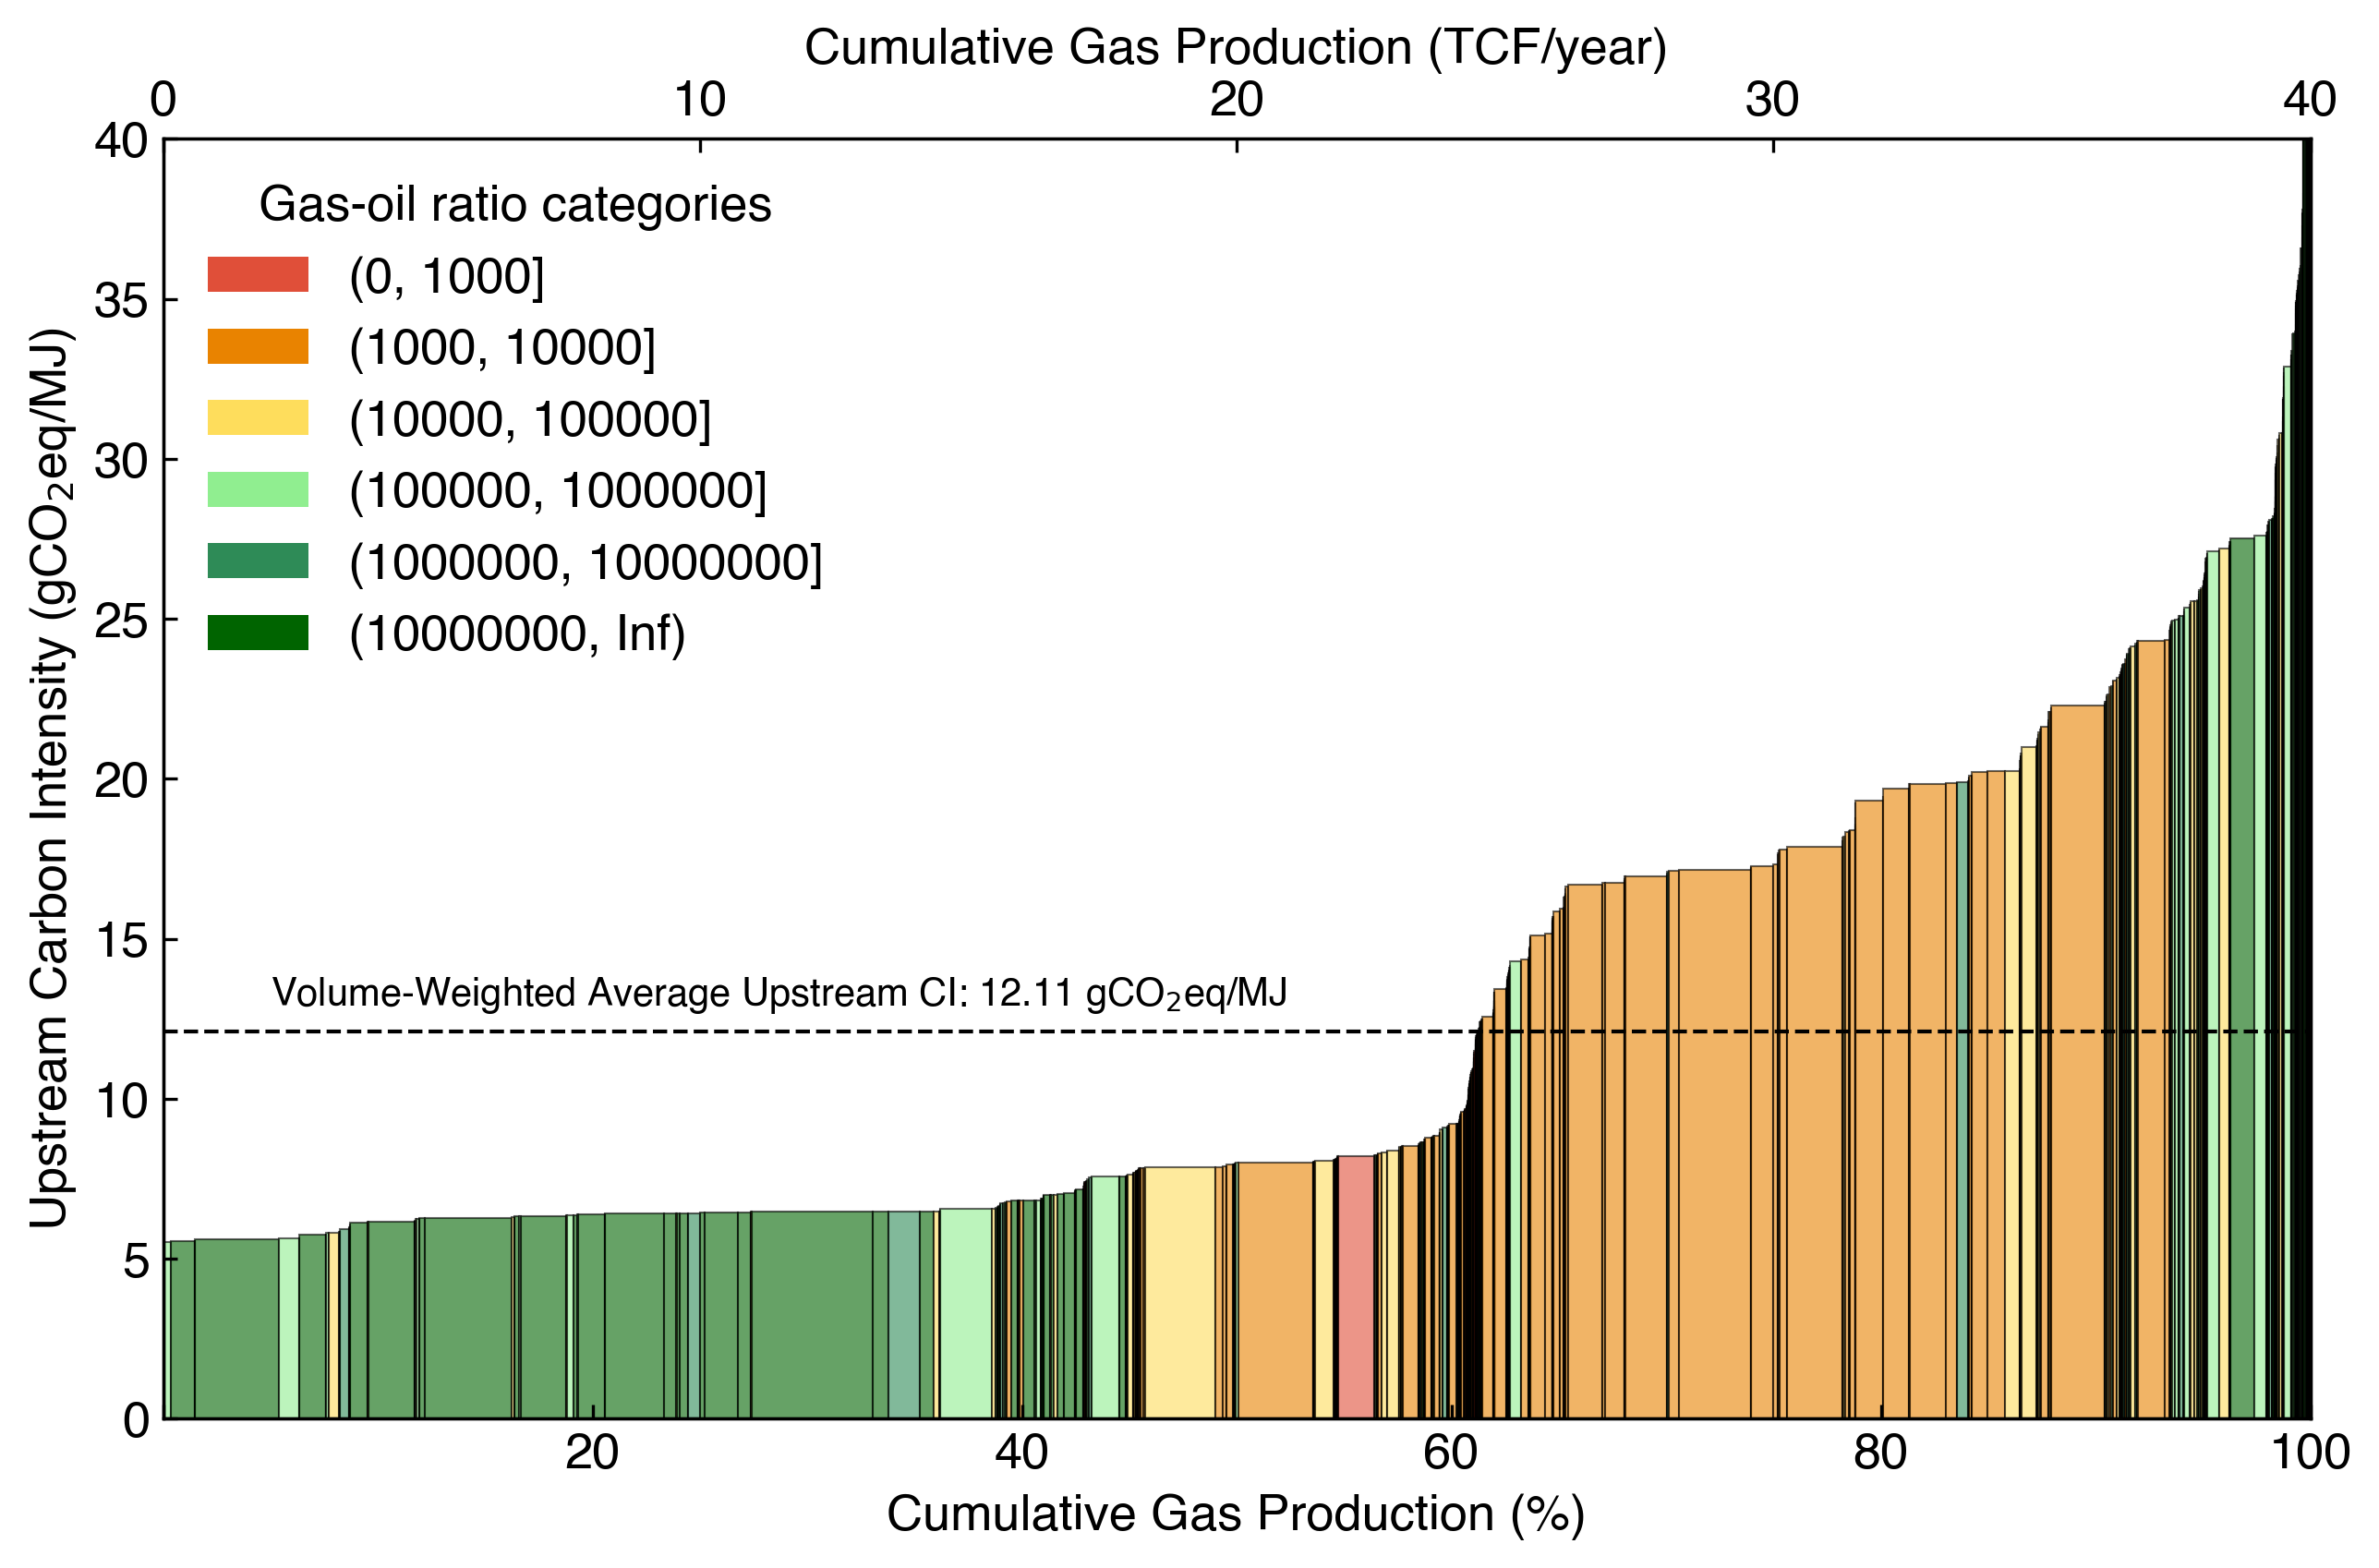

In [131]:
# Set the font properties globally
plt.rcParams['font.family'] = 'Helvetica'
# You can also adjust the size globally here
plt.rcParams['font.size'] = 13

df_viz['GOR'] = df_viz['Annual_Gas']*1000 /df_viz['Annual_Oil']

# Define new conditions for five GOR categories
conditions = [
    (df_viz['GOR'] <= 1000),  # GOR up to 100
    (df_viz['GOR'] > 1000) & (df_viz['GOR'] <= 10000),   # GOR up to 100
    (df_viz['GOR'] > 10000) & (df_viz['GOR'] <= 100000),  # GOR from 100 to 150
    (df_viz['GOR'] > 100000) & (df_viz['GOR'] <= 1000000),  # GOR from 150 to 200
    (df_viz['GOR'] > 1000000) & (df_viz['GOR'] <= 10000000),  # GOR from 200 to 250
    (df_viz['GOR'] > 10000000)  # GOR greater than 250
]

# Define specific colors for each of the new conditions
# colors = ['palegreen', 'springgreen',
#           'mediumseagreen', 'seagreen', 'darkgreen']

# colors = ['red', 
#          'orange',
#          'yellow', 
#          'lightgreen',
#          'seagreen', 
#          'darkgreen'
#          ]

# stanford color
colors = ['#E04F39', # sprited red
          '#E98300', # poppy orange
          '#FEDD5C', # illuminating yellow
          'lightgreen',
          'seagreen',
          'darkgreen'
          ]

# Applying the conditions to create a new column for color
df_viz['color'] = np.select(conditions, colors)

# Create a higher quality figure
plt.figure(figsize=(10, 6), dpi=300)  # Larger figure size and higher DPI

# Plotting the bar chart
bars = plt.bar(df_viz['left'], df_viz['CI_gCO2_MJ'], width=df_viz['width'], color=df_viz['color'],
               alpha=0.6, align='edge', edgecolor='k', linewidth=0.5)

#df_calc = df_viz[df_viz['CI_gCO2_MJ'] < 40]
df_calc = df_viz

mean_CI_gCO2_MJ = (df_calc['CI_gCO2_MJ'] * df_calc['Annual_Gas']).sum() / df_calc['Annual_Gas'].sum()

#mean_CI_gCO2_MJ = 12.07

# Adding a horizontal dotted line for the mean Carbon Intensity
plt.axhline(y=mean_CI_gCO2_MJ, color='k', linestyle='--',
            linewidth=1, label=f'Mean CI: {mean_CI_gCO2_MJ:.2f}')
# Annotate the line with text
plt.text(0.05, mean_CI_gCO2_MJ + 0.5, f'Volume-Weighted Average Upstream CI: {mean_CI_gCO2_MJ:.2f} gCO$_2$eq/MJ',
         verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=10)


# Setting the y-axis limits
plt.ylim(0, 40)
plt.xlim(0,1)

# Custom tick labels, excluding '0.0'
x_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]  # Setting tick marks from 0 to 1, every 5 units
# Replace '0' with an empty string
x_labels = [str(int(tick*100)) if tick != 0 else '' for tick in x_ticks]
plt.xticks(x_ticks, x_labels)

# Setting tick marks to be inside
plt.gca().tick_params(direction='in')

# Optional: Adding labels and title for clarity
plt.xlabel(r'Cumulative Gas Production (%)')  # Replace 'Category' with your actual x-axis label
plt.ylabel(r'Upstream Carbon Intensity (gCO$_2$eq/MJ)')

legend_labels = [
    r'(0, 1000]',
    r'(1000, 10000]',
    r'(10000, 100000]',
    r'(100000, 1000000]',
    r'(1000000, 10000000]',
    r'(10000000, Inf)'
] 
legend_colors = colors
legend_handles = [Patch(facecolor=col, label=label)
                  for col, label in zip(legend_colors, legend_labels)]
plt.legend(handles=legend_handles, title = "Gas-oil ratio categories", frameon=False)

# Adding a secondary x-axis on top
ax1 = plt.gca()
ax2 = ax1.twiny()

annual_production = 40
print(annual_production)

# Setting the ticks and labels for the secondary x-axis
top_x_ticks = [
    i / annual_production for i in range(0, annual_production+1, 10)]
top_x_labels = [f'{i}' for i in range(0, annual_production+1, 10)]
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(top_x_ticks)
ax2.set_xticklabels(top_x_labels)
ax2.set_xlabel("Cumulative Gas Production (TCF/year)")
ax2.tick_params(direction='in')

# Save the figure
plt.savefig('/Users/spencerzhang/GitHub/PhD/North-America-Gas-2021/NAG publishable plot/Cumulative_Gas_Production_Plot.svg',
            format='svg', dpi=300)

# Show the plot
plt.show()


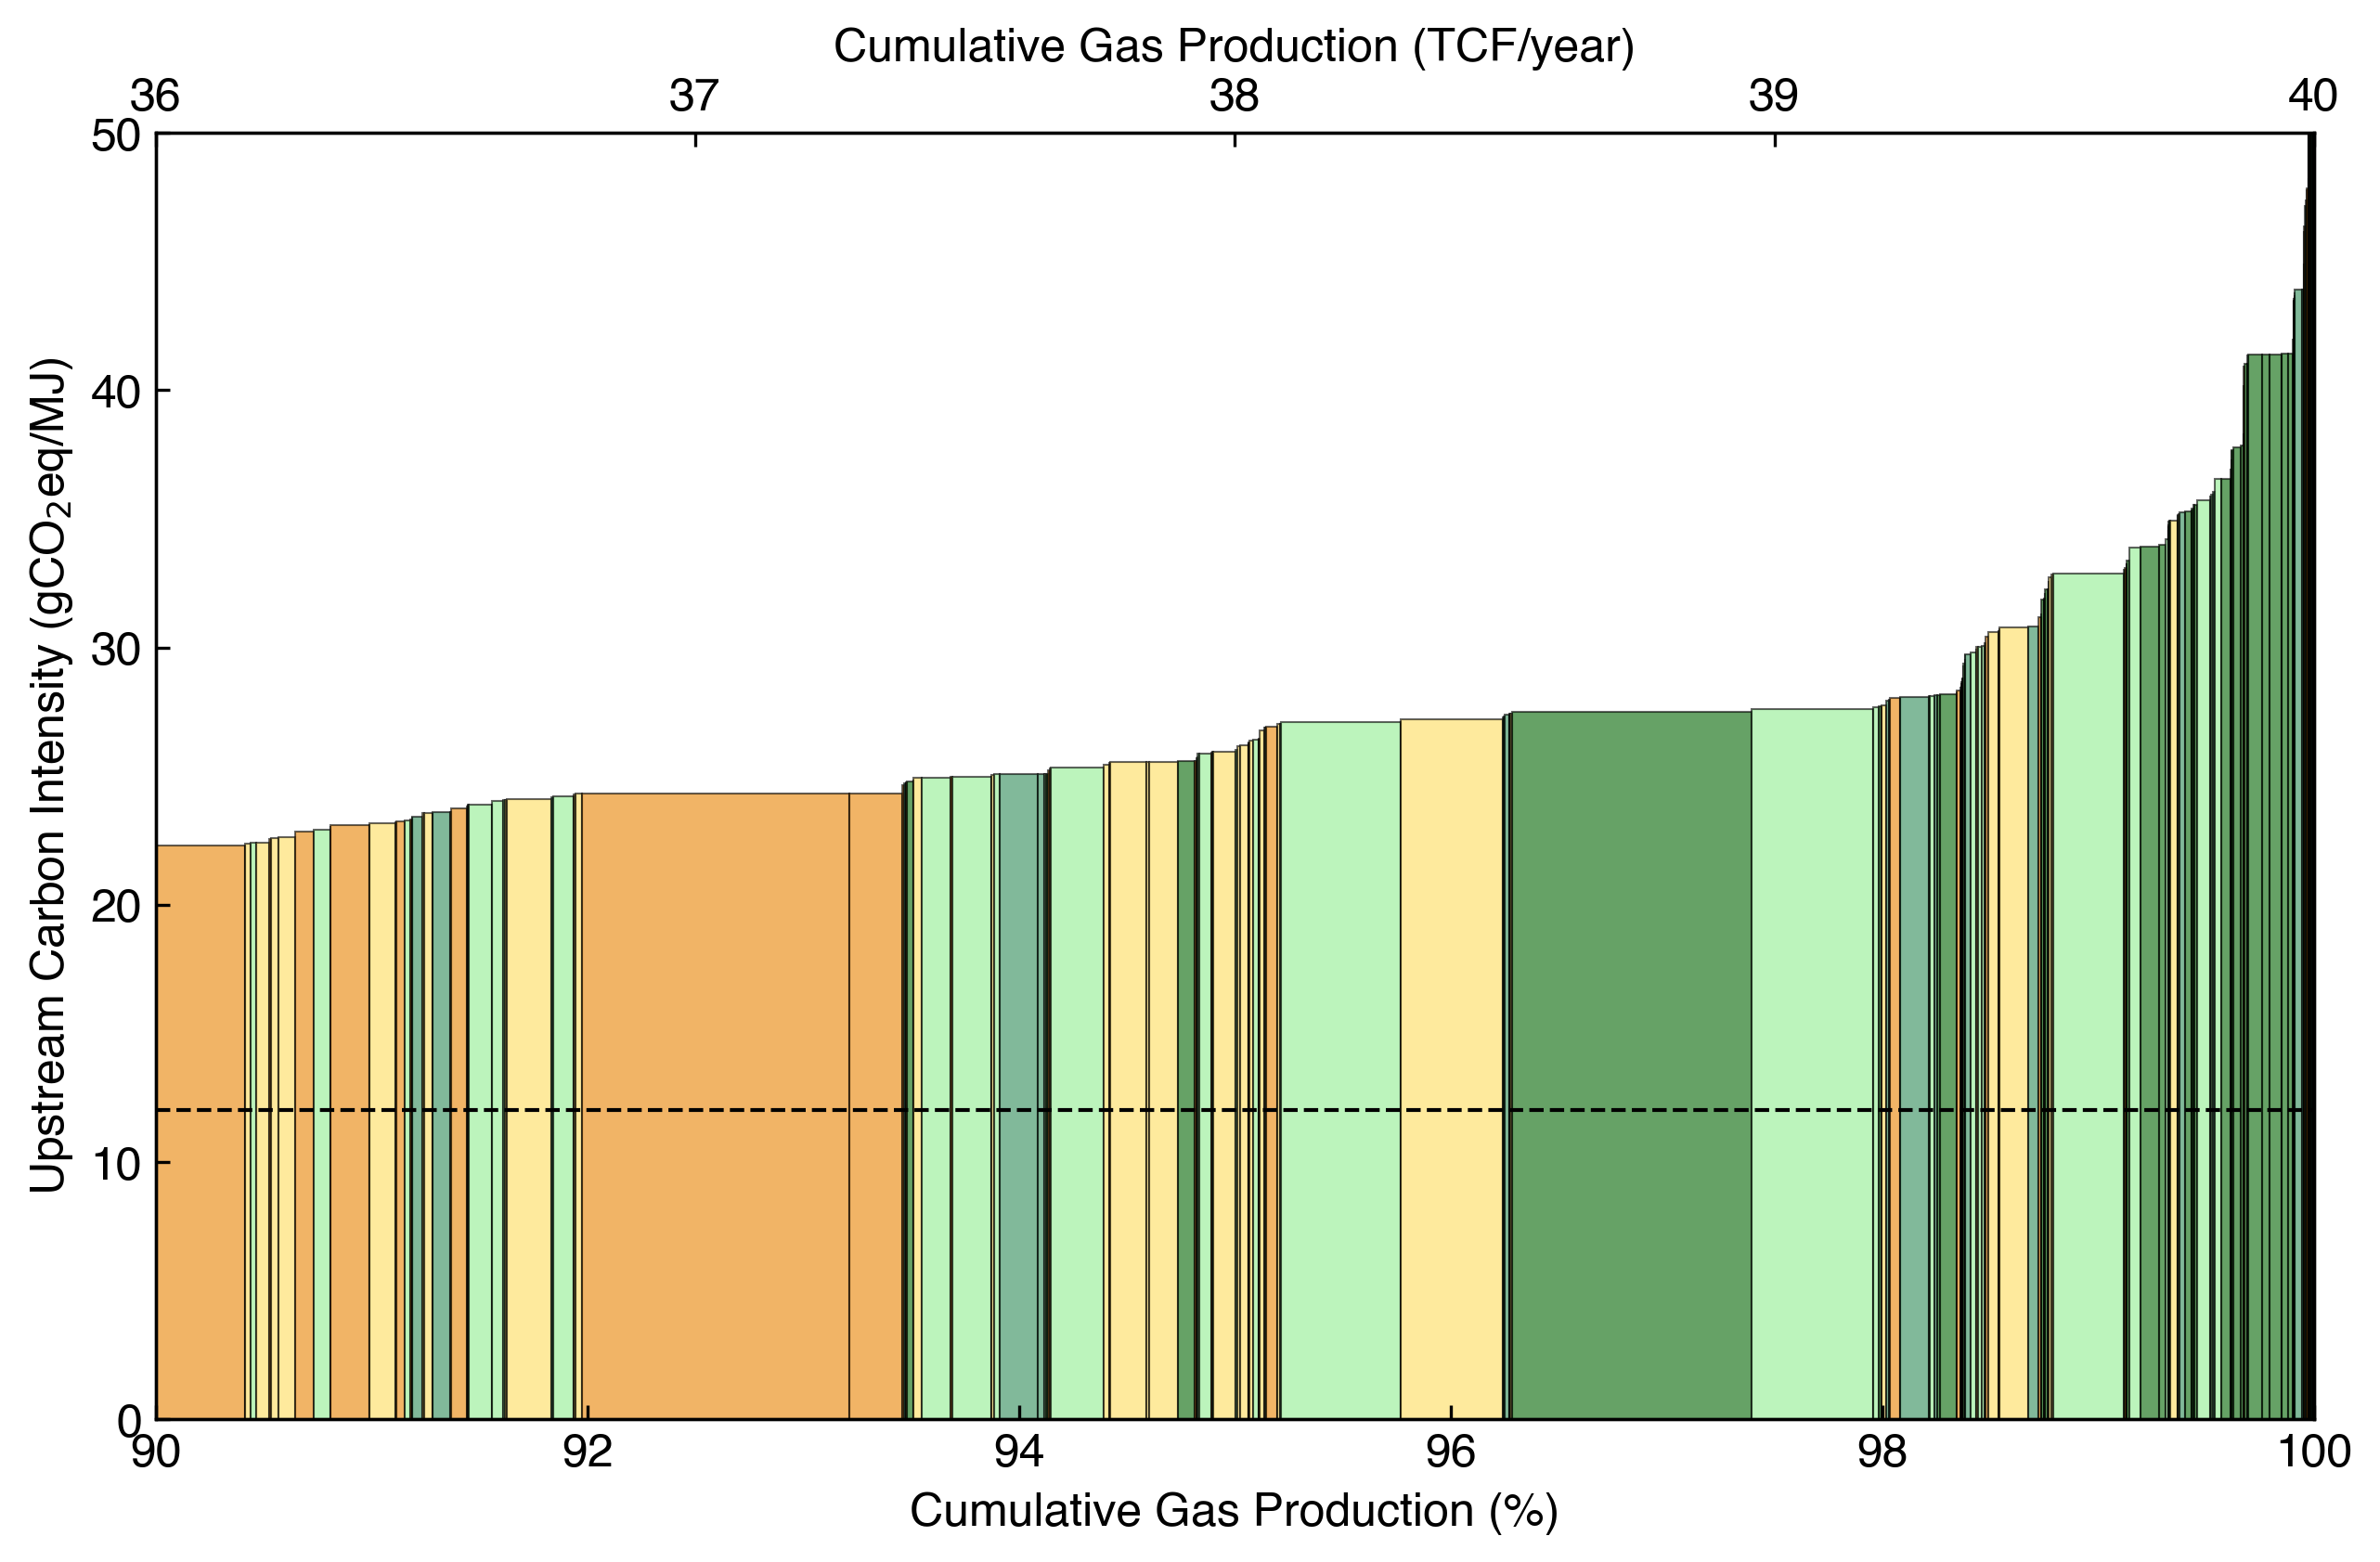

In [138]:
# Set the font properties globally
plt.rcParams['font.family'] = 'Helvetica'
# You can also adjust the size globally here
plt.rcParams['font.size'] = 12

df_viz['GOR'] = df_viz['Annual_Gas']*1000 /df_viz['Annual_Oil']

# Define new conditions for five GOR categories
conditions = [
    (df_viz['GOR'] <= 1000),  # GOR up to 100
    (df_viz['GOR'] > 1000) & (df_viz['GOR'] <= 10000),   # GOR up to 100
    (df_viz['GOR'] > 10000) & (df_viz['GOR'] <= 100000),  # GOR from 100 to 150
    (df_viz['GOR'] > 100000) & (df_viz['GOR'] <= 1000000),  # GOR from 150 to 200
    (df_viz['GOR'] > 1000000) & (df_viz['GOR'] <= 10000000),  # GOR from 200 to 250
    (df_viz['GOR'] > 10000000)  # GOR greater than 250
]

# Define specific colors for each of the new conditions
# colors = ['palegreen', 'springgreen',
#           'mediumseagreen', 'seagreen', 'darkgreen']

# colors = ['red', 'orange','yellow', 
#             'lightgreen','seagreen', 'darkgreen']

# stanford color
colors = ['#E04F39',  # sprited red
          '#E98300',  # poppy orange
          '#FEDD5C',  # illuminating yellow
          'lightgreen',
          'seagreen',
          'darkgreen'
          ]

# Applying the conditions to create a new column for color
df_viz['color'] = np.select(conditions, colors)

# Create a higher quality figure
plt.figure(figsize=(10, 6), dpi=300)  # Larger figure size and higher DPI

# Plotting the bar chart
bars = plt.bar(df_viz['left'], df_viz['CI_gCO2_MJ'], width=df_viz['width'], color=df_viz['color'],
               alpha=0.6, align='edge', edgecolor='k', linewidth=0.5)

df_calc = df_viz[df_viz['CI_gCO2_MJ'] < 40]

mean_CI_gCO2_MJ = (df_calc['CI_gCO2_MJ'] * df_calc['Annual_Gas']
                   ).sum() / df_calc['Annual_Gas'].sum()

# Adding a horizontal dotted line for the mean Carbon Intensity
plt.axhline(y=mean_CI_gCO2_MJ, color='k', linestyle='--',
            linewidth=1, label=f'Mean CI: {mean_CI_gCO2_MJ:.2f}')
# Annotate the line with text
#plt.text(0.95, mean_CI_gCO2_MJ + 0.5, f'The volume-weighted average upstream CI: {mean_CI_gCO2_MJ:.2f} gCO$_2$eq/MJ',
#         verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=10)


# Setting the y-axis limits
plt.ylim(0, 50)
plt.xlim(0.9,1)

# Custom tick labels for the narrowed x-axis range
x_ticks = [0.9, 0.92, 0.94, 0.96, 0.98, 1.0]
# Replace '0' with an empty string
x_labels = [str(int(tick*100)) if tick != 0 else '' for tick in x_ticks]
plt.xticks(x_ticks, x_labels)

plt.gca().tick_params(direction='in')

plt.xlabel(r'Cumulative Gas Production (%)')
plt.ylabel(r'Upstream Carbon Intensity (gCO$_2$eq/MJ)')

# legend_labels = [
#     r'(0, 1000]',
#     r'(1000, 10000]',
#     r'(10000, 100000]',
#     r'(100000, 1000000]',
#     r'(1000000, 10000000]',
#     r'(10000000, Inf)'
# ] 
# legend_colors = colors
# legend_handles = [Patch(facecolor=col, label=label)
#                   for col, label in zip(legend_colors, legend_labels)]
# plt.legend(handles=legend_handles, title = "Gas-oil ratio categories", frameon=False)

# Adding a secondary x-axis on top
ax1 = plt.gca()
ax2 = ax1.twiny()

annual_production = 40
# print(annual_production)

# Setting the ticks and labels for the secondary x-axis
top_x_ticks = [
    i / annual_production for i in range(36, annual_production+1, 1)]
top_x_labels = [f'{i}' for i in range(36, annual_production+1, 1)]
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(top_x_ticks)
ax2.set_xticklabels(top_x_labels)
ax2.set_xlabel("Cumulative Gas Production (TCF/year)")
ax2.tick_params(direction='in')

# # Save the figure
# plt.savefig('/Users/spencerzhang/GitHub/PhD/North-America-Gas-2021/NAG publishable plot/Cumulative_Gas_Production_Plot.svg',
#             format='svg', dpi=300)

# Show the plot
plt.show()


## Figure 3.1 policy

In [35]:
fpath = "/Users/spencerzhang/GitHub/PhD/North-America-Gas-2021/NAG runs/Policy run/policy_visualization/"
df_base = pd.read_csv(fpath + "df_base.csv")
df_flare_5 = pd.read_csv(fpath + "df_flare_5.csv")
df_flare_25 = pd.read_csv(fpath + "df_flare_25.csv")
df_extreme = pd.read_csv(fpath + "df_extreme.csv")
df_vf_50 = pd.read_csv(fpath + "df_vf_50.csv")
df_vf_75 = pd.read_csv(fpath + "df_vf_75.csv")


40


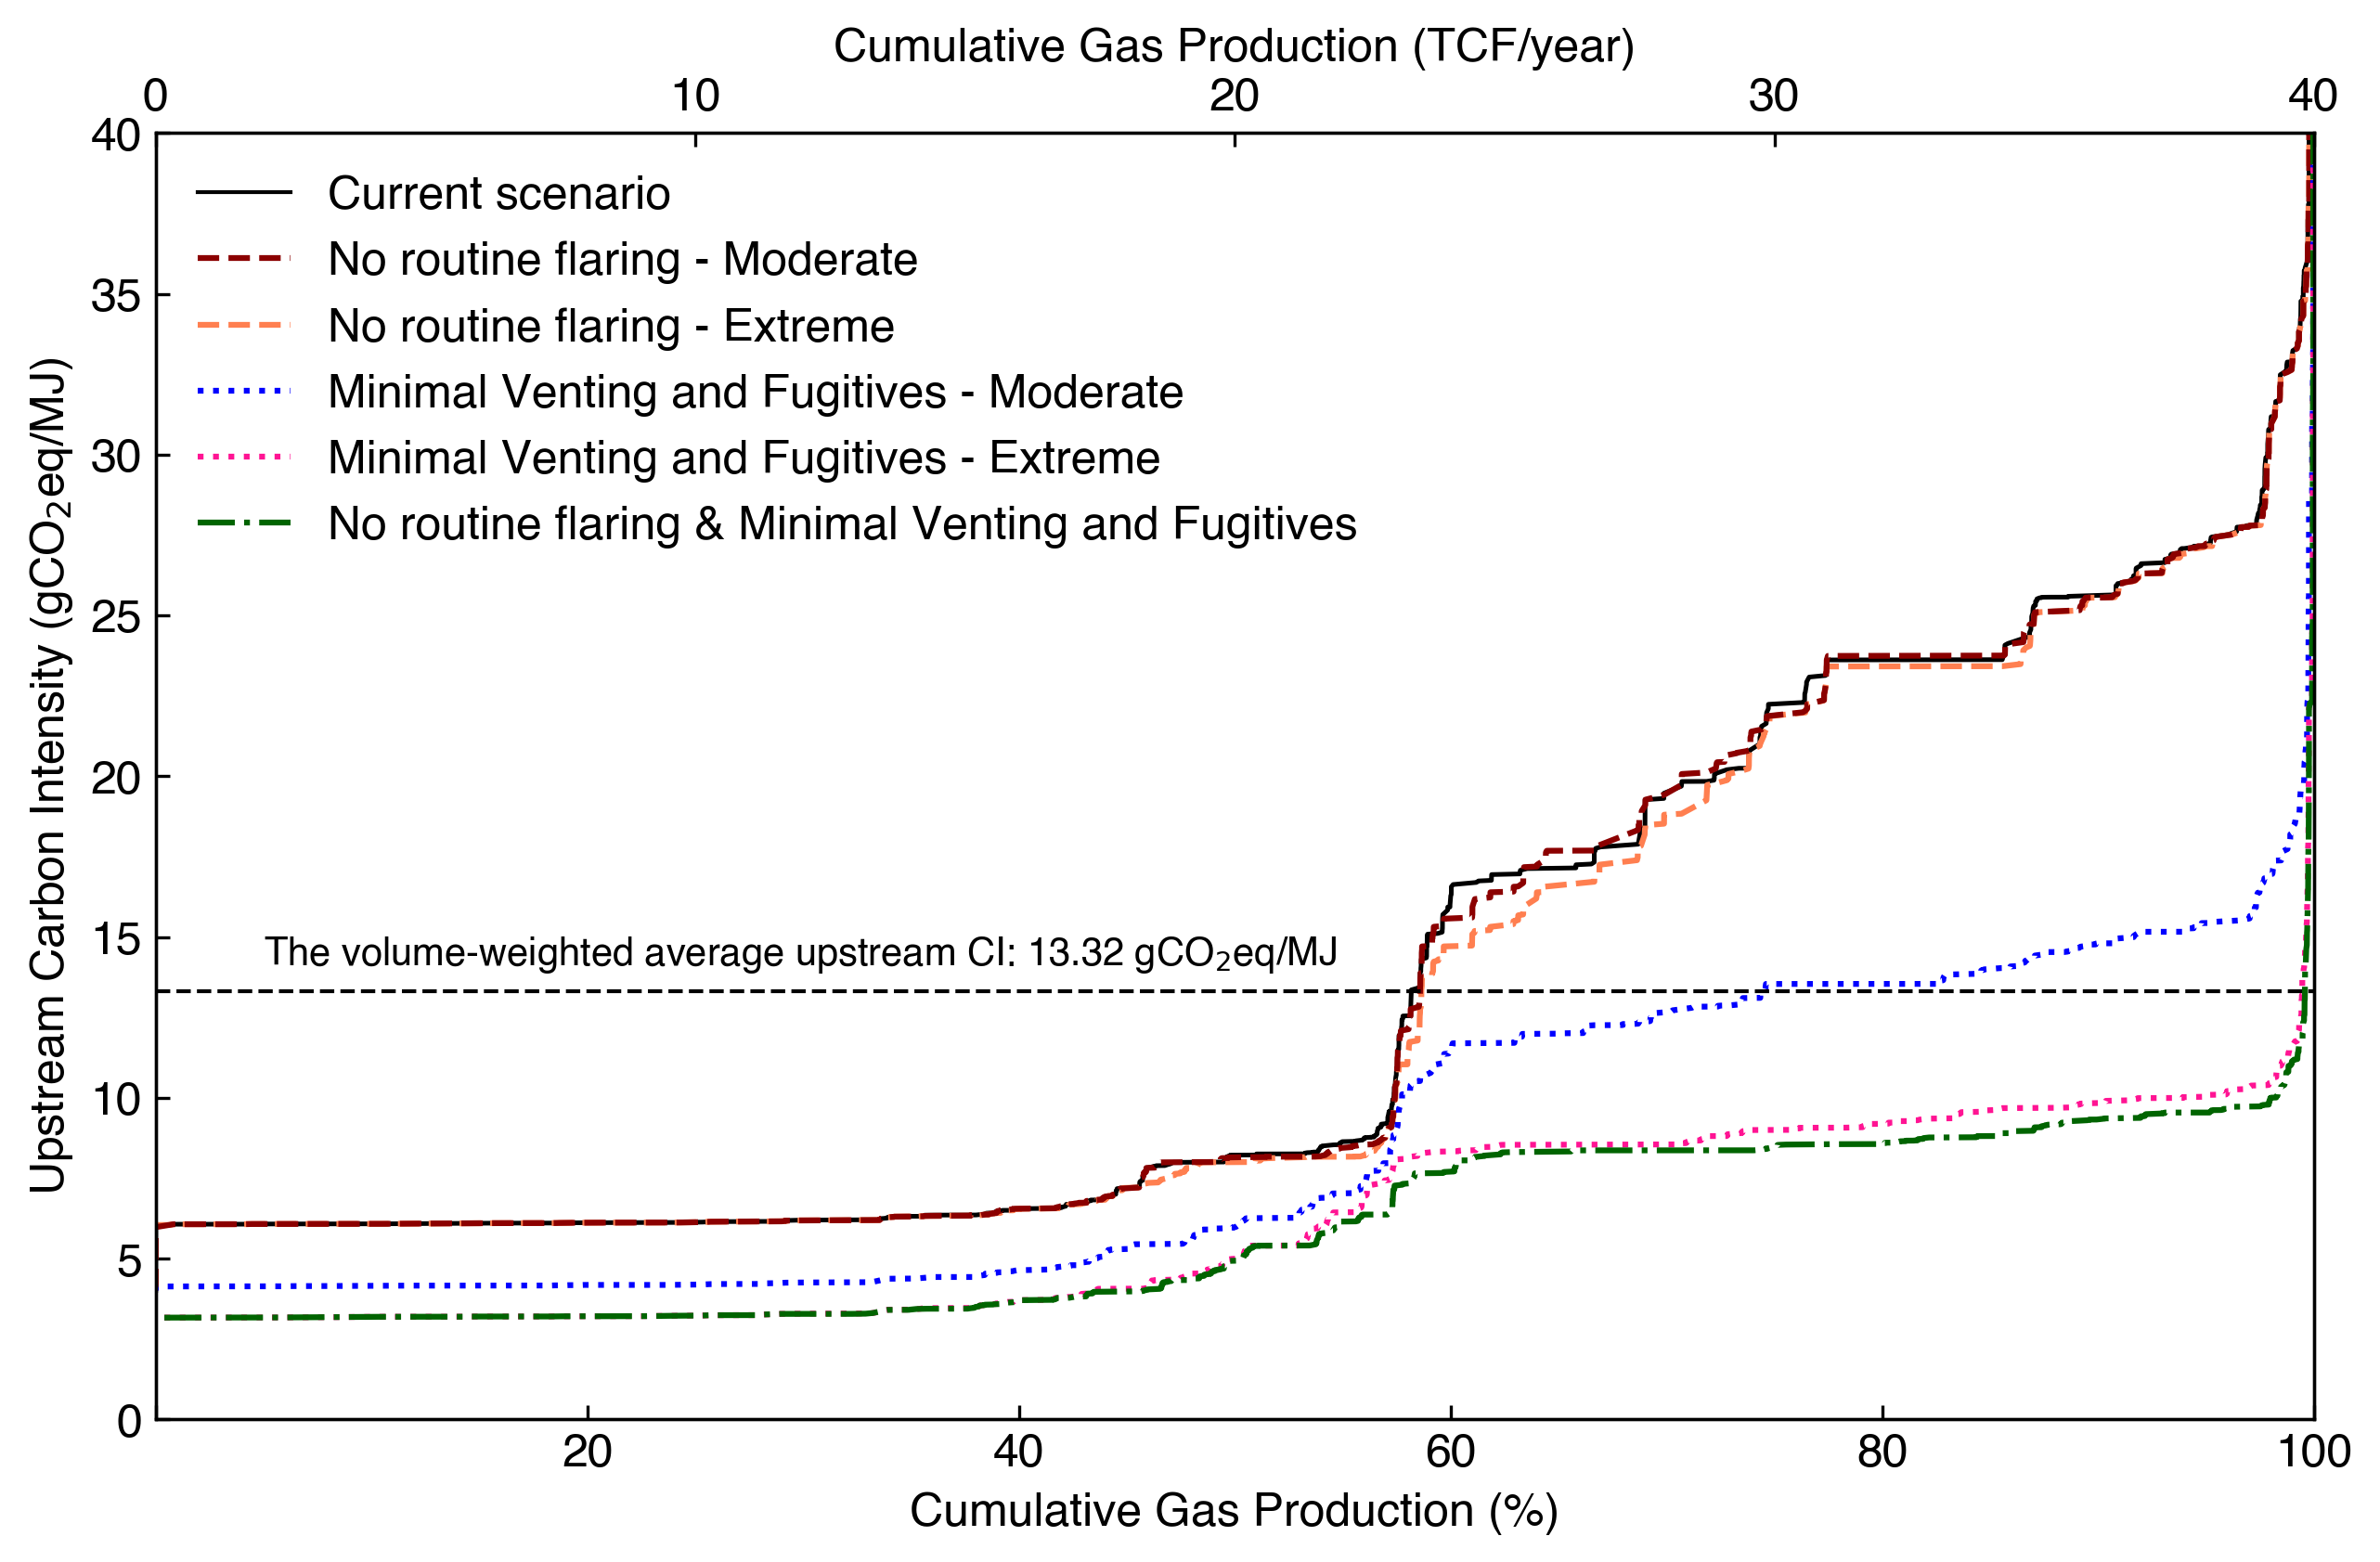

In [132]:
# Set the font properties globally
plt.rcParams['font.family'] = 'Helvetica'
# You can also adjust the size globally here
plt.rcParams['font.size'] = 12



colors = ['red', 'orange','yellow', 
            'lightgreen','seagreen', 'darkgreen']

# Create a higher quality figure
plt.figure(figsize=(10, 6), dpi=300)  # Larger figure size and higher DPI

# Plotting the bar chart

cum_curve = plt.plot(df_base['gas_cum'], df_base['CI_gCO2_MJ'],
               alpha=1, linewidth=1.2, color = "black")
cum_curve2 = plt.plot(df_flare_5['gas_cum'], df_flare_5['CI_gCO2_MJ'],
                     alpha=1, linewidth=1.5, ls="dashed", color="coral")
cum_curve3 = plt.plot(df_flare_25['gas_cum'], df_flare_25['CI_gCO2_MJ'],
                     alpha=1, linewidth=1.5, ls="dashed", color="darkred")
cum_curve5 = plt.plot(df_vf_50['gas_cum'], df_vf_50['CI_gCO2_MJ'],
                      alpha=1, linewidth=1.5, ls="dotted", color="blue")
cum_curve6 = plt.plot(df_vf_75['gas_cum'], df_vf_75['CI_gCO2_MJ'],
                      alpha=1, linewidth=1.5, ls="dotted", color="deeppink")
cum_curve4 = plt.plot(df_extreme['gas_cum'], df_extreme['CI_gCO2_MJ'],
                      alpha=1, linewidth=1.5, ls="dashdot", color="darkgreen")

# ls loosely dotted or dotted
# color yellow green GreenYellow
# color darkorange 
# color gold
df_calc = df_base[df_base['CI_gCO2_MJ'] < 40]

mean_CI_gCO2_MJ = (df_calc['CI_gCO2_MJ'] * df_calc['Annual_Gas']
                   ).sum() / df_calc['Annual_Gas'].sum()

# Adding a horizontal dotted line for the mean Carbon Intensity
plt.axhline(y=mean_CI_gCO2_MJ, color='k', linestyle='--',
            linewidth=1, label=f'Mean CI: {mean_CI_gCO2_MJ:.2f}')
# Annotate the line with text
plt.text(0.05, mean_CI_gCO2_MJ + 0.5, f'The volume-weighted average upstream CI: {mean_CI_gCO2_MJ:.2f} gCO$_2$eq/MJ',
         verticalalignment='bottom', horizontalalignment='left', color='black', fontsize=10)


# Setting the y-axis limits
plt.ylim(0, 40)
plt.xlim(0,1)

# Custom tick labels, excluding '0.0'
x_ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]  # Setting tick marks from 0 to 1, every 5 units
# Replace '0' with an empty string
x_labels = [str(int(tick*100)) if tick != 0 else '' for tick in x_ticks]
plt.xticks(x_ticks, x_labels)

# Setting tick marks to be inside
plt.gca().tick_params(direction='in')

# Optional: Adding labels and title for clarity
plt.xlabel(r'Cumulative Gas Production (%)')  # Replace 'Category' with your actual x-axis label
plt.ylabel(r'Upstream Carbon Intensity (gCO$_2$eq/MJ)')

# Creating custom legend handles with Line2D objects
legend_lines = [
    Line2D([0], [0], color='black', linewidth=1, linestyle='-'),
    Line2D([0], [0], color='darkred', linewidth=1.5, linestyle='--'),
    Line2D([0], [0], color='coral', linewidth=1.5, linestyle='--'),
    Line2D([0], [0], color='blue', linewidth=1.5, linestyle='dotted'),
    Line2D([0], [0], color='deeppink', linewidth=1.5, linestyle='dotted'),
    Line2D([0], [0], color='darkgreen', linewidth=1.5, linestyle='dashdot')
]

legend_labels = [
    r'Current scenario',
    r'No routine flaring - Moderate',
    r'No routine flaring - Extreme',
    r'Minimal Venting and Fugitives - Moderate',
    r'Minimal Venting and Fugitives - Extreme',
    r'No routine flaring & Minimal Venting and Fugitives',
]

# Adding a secondary x-axis on top
ax1 = plt.gca()
ax2 = ax1.twiny()

annual_production = int(df_base['Annual_Gas'].sum()/1e9)
print(annual_production)

# Setting the ticks and labels for the secondary x-axis
top_x_ticks = [i / annual_production for i in range(0, annual_production+1, 10)]
top_x_labels = [f'{i}' for i in range(0, annual_production+1, 10)]
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(top_x_ticks)
ax2.set_xticklabels(top_x_labels)
ax2.set_xlabel("Cumulative Gas Production (TCF/year)")
ax2.tick_params(direction='in')

plt.legend(handles=legend_lines, labels=legend_labels, frameon=False,loc = "upper left")


# Save the figure
plt.savefig('/Users/spencerzhang/GitHub/PhD/North-America-Gas-2021/NAG publishable plot/policy_implication.svg',
            format='svg', dpi=1200)

# Show the plot
plt.show()

# Figure 4 CI on map

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

/Users/spencerzhang/opt/anaconda3/envs/dsenv/lib/python3.9/site-packages/geopandas/_compat.py:153: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
/var/folders/g6/rg58f3ds4jj7c23g1xr0j25m0000gn/T/ipykernel_88703/3679987922.py:1: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


In [4]:
# Load GeoJSON
# Load the GeoJSON data
df_viz_centroid = gpd.read_file(
    "/Users/spencerzhang/GitHub/PhD/North-America-Gas-2021/NAG publishable plot/df_viz_centroid.geojson")

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Load the base map of US states
states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us_states = states[states['continent'] == 'North America']

# Create a figure and axis with a specific projection
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot US boundaries
us_states.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)

# Define color and size ranges
color_map = {
    "0-10": "green",
    "10-20": "yellow",
    "20-50": "gold",
    "50-100": "orange",
    "100-500": "coral",
    ">500": "red"
}

df_viz_centroid['colors'] = df_viz_centroid['CI_cate'].map(color_map)

# Plotting the centroids
df_viz_centroid.plot(
    ax=ax, marker='o', color=df_viz_centroid['colors'],
    markersize=df_viz_centroid['Annual_Gas'] / 1e7, edgecolor='black', linewidth=0.3
)

# Add legend for color
for category, color in color_map.items():
    ax.scatter([], [], c=color, label=category, edgecolor='black')

# Adjusting legend for color
legend1 = ax.legend(title='Carbon Intensity Range \n gCO2e MJ^-1',
                    loc='upper left', bbox_to_anchor=(1, 1))
ax.add_artist(legend1)

# Add legend for size
for size in [1e9, 2e9, 3e9, 4e9, 5e9]:
    ax.scatter([], [], c='gray', alpha=0.5, s=size / 1e7,
               edgecolor='black', label=str(int(size / 1e9)) + ' MMSCF')

# Adjusting legend for size
legend2 = ax.legend(title='Annual Gas (MMSCF)',
                    loc='lower left', bbox_to_anchor=(1, 0))
ax.add_artist(legend2)

# Remove axes and add titles
ax.set_axis_off()
plt.title('Gas Transmission between States with Carbon Intensity', fontsize=16)

plt.show()


/Users/spencerzhang/opt/anaconda3/envs/dsenv/lib/python3.9/site-packages/geopandas/_compat.py:153: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
/var/folders/g6/rg58f3ds4jj7c23g1xr0j25m0000gn/T/ipykernel_55271/3816128404.py:1: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd
/var/folders/g6/rg58f3ds4jj7c23g1xr0j25m0000gn/T/ipykernel_55271/3816128404.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  states = gpd.read_file(g

: 

: 

# Figure 5 midstream allocation

## F5 data prep

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the CSV file
file_path = '/Users/spencerzhang/GitHub/PhD/North-America-Gas-2021/NAG publishable plot/midstream_matrix_no_coords.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
df.columns

Index(['prod_state_fip', 'prod_state_short', 'prod_state_name',
       'delivery_state_short', 'transmitted_gas_MCF',
       'midstream_factor_kgCO2_MMCF', 'midstream_factor_gCO2_MJ',
       'delivery_state_name', 'emission_tCO2'],
      dtype='object')

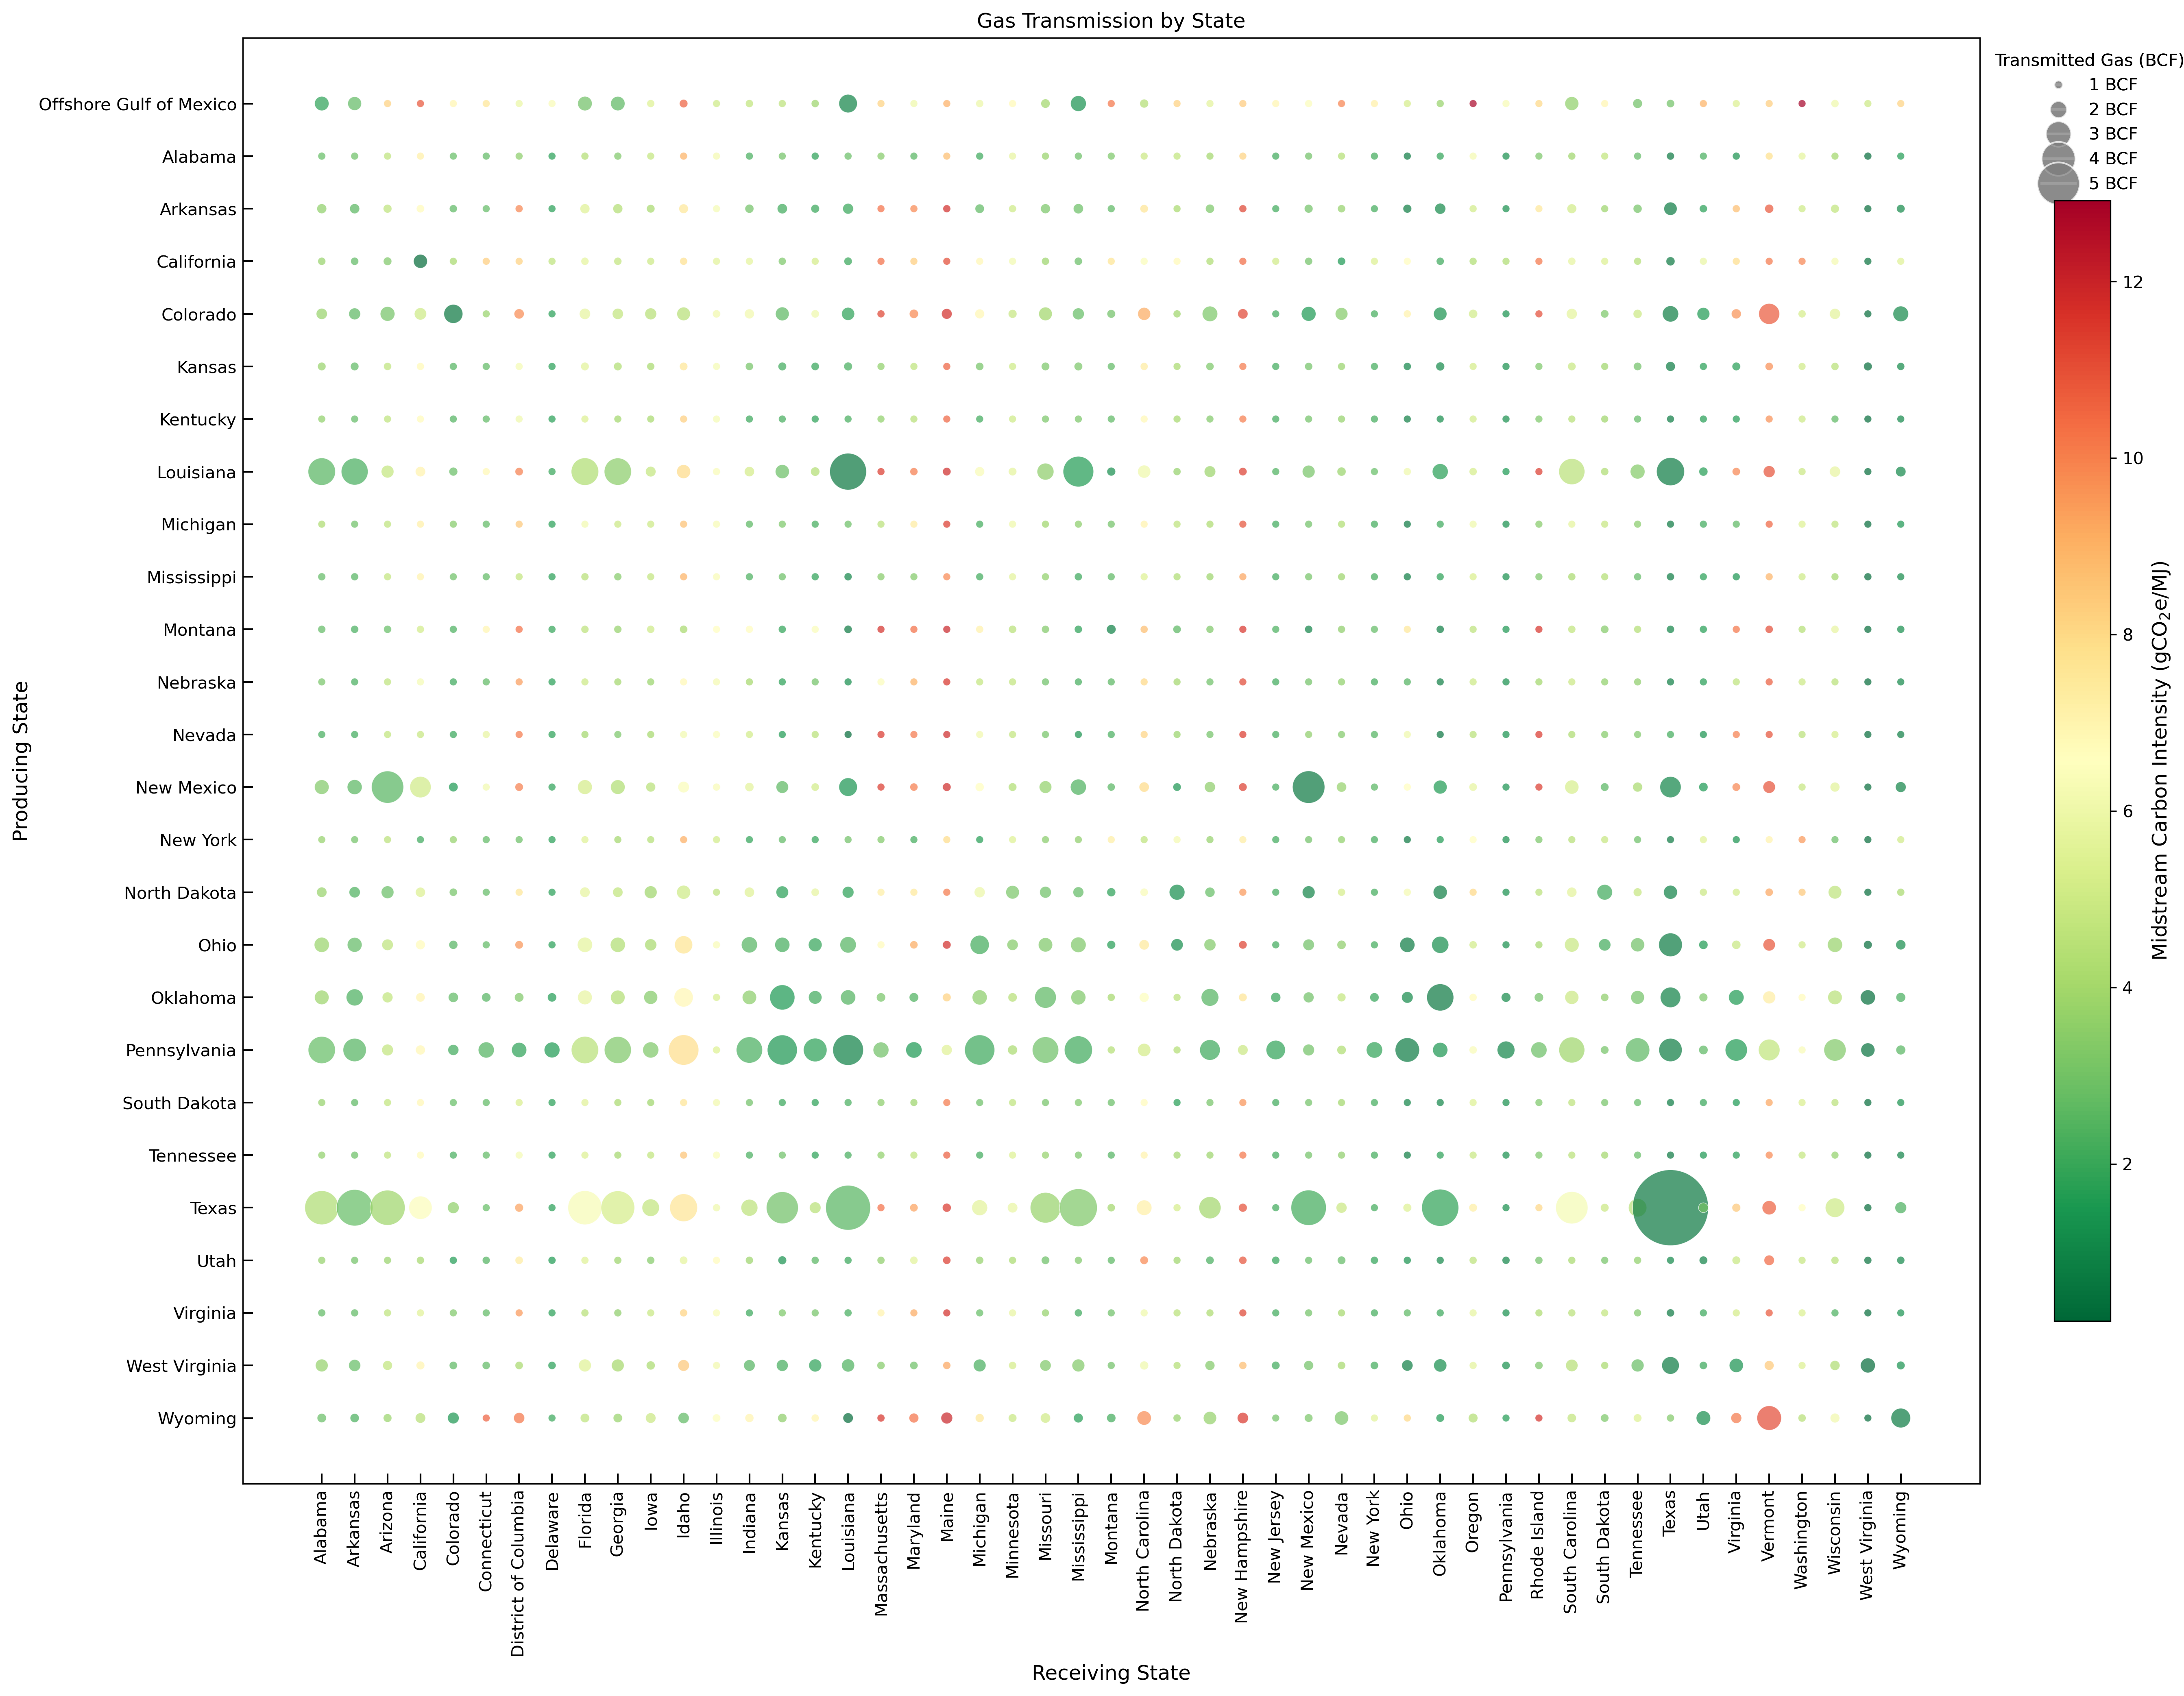

In [3]:
# Create the bubble plot
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from matplotlib.cm import ScalarMappable

plt.figure(figsize=(18, 14), dpi=300)
df['transmitted_gas_BCF'] = df['transmitted_gas_MCF']/1000000
#df = df[df['transmitted_gas_BCF'] > 0.001]

bubble_plot = sns.scatterplot(
    data=df,
    y='prod_state_name',
    x='delivery_state_name',
    size='transmitted_gas_BCF',
    hue='midstream_factor_gCO2_MJ',
    palette='RdYlGn_r',
    sizes=(20, 2000),
    #legend='brief',
    edgecolor='w',
    alpha=0.7
)

# Add titles and labels
bubble_plot.set_title('Gas Transmission by State', fontsize=12)
bubble_plot.set_ylabel('Producing State', fontsize=12)
bubble_plot.set_xlabel('Receiving State', fontsize=12)


# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Custom size legend
size_legend_handles = [
    Line2D([0], [0], marker='o', color='w', label='1 BCF',
           markersize=5, 
           markerfacecolor='gray', 
           alpha=0.7),
    Line2D([0], [0], marker='o', color='w', label='2 BCF',
           markersize=10, markerfacecolor='gray', alpha=0.7),
    Line2D([0], [0], marker='o', color='w', label='3 BCF',
           markersize=15, markerfacecolor='gray', alpha=0.7),
    Line2D([0], [0], marker='o', color='w', label='4 BCF',
           markersize=20, markerfacecolor='gray', alpha=0.7),
    Line2D([0], [0], marker='o', color='w', label='5 BCF',
           markersize=25, markerfacecolor='gray', alpha=0.7)
]

size_legend = plt.legend(handles=size_legend_handles,
                         title='Transmitted Gas (BCF)', loc='upper left', bbox_to_anchor=(1, 1),
                         frameon = False)
plt.gca().add_artist(size_legend)

# Create a colorbar for the continuous hue scale
norm = Normalize(vmin=df['midstream_factor_gCO2_MJ'].min(),
                 vmax=df['midstream_factor_gCO2_MJ'].max())
sm = ScalarMappable(norm=norm, cmap='RdYlGn_r')
sm.set_array([])

cbar = plt.colorbar(sm, ax=bubble_plot, fraction=0.03, pad=0.04)
cbar.set_label(r'Midstream Carbon Intensity (gCO$_2$e/MJ)', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Set ticks to be inside the axis
bubble_plot.tick_params(axis='x', direction='in', length=6, width=1)
bubble_plot.tick_params(axis='y', direction='in', length=6, width=1)

# Display the plot
plt.tight_layout()
plt.show()


In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Load the base map of US states
states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
us_states = states[states['continent'] == 'North America']

# Create a figure and axis with a specific projection
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot US boundaries
us_states.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)


/Users/spencerzhang/opt/anaconda3/envs/dsenv/lib/python3.9/site-packages/geopandas/_compat.py:153: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
/var/folders/g6/rg58f3ds4jj7c23g1xr0j25m0000gn/T/ipykernel_88747/284079125.py:1: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd
/var/folders/g6/rg58f3ds4jj7c23g1xr0j25m0000gn/T/ipykernel_88747/284079125.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  states = gpd.read_file(gpd

: 

: 